# 熱中症患者数予測
#### 気象データから熱中症患者数を予測する回帰モデルを作成する

### 02.prdict.ipynb
学習モデルの性能評価・推論。

In [1]:
import azureml
from azureml.core import Workspace, Run

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.57


## 1. デプロイされたモデルを取得

In [2]:
from azureml.core import Workspace
from azureml.core.model import Model
import os
ws = Workspace.from_config()
model = Model(ws, "heatstroke_model")
model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "model.pkl")

os.stat(file_path)
print(file_path)

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FMYDLXG2A to authenticate.
Interactive authentication successfully completed.
/home/nbuser/library/model.pkl


In [3]:
import pickle
from sklearn.externals import joblib
import azureml.train.automl
model_path = Model.get_model_path('model.pkl')
model = joblib.load(model_path)

## 2. モデルの性能評価

### トレーニングデータ・テストデータの準備・処理

In [4]:
import pandas as pd
df_train = pd.read_csv('./data/Heatstroke_patient_prediction_train_data.csv') # トレーニングデータ(~2017年)の読み込み
df_test = pd.read_csv('./data/Heatstroke_patient_prediction_test_data.csv') # テストデータ(2018年のみ)の読み込み

In [5]:
df_train.head(10)

,年月日,搬送人員（計）,最高気温(℃),平均気温(℃),最低気温(℃),日照時間(時間),平均風速(m/s),平均雲量(10分比),平均湿度(％),降水量の合計(mm),...,m前日最高気温との差,m前日平均気温との差,m前日最低気温との差,m最高気温移動平均(5日間),m平均気温移動平均(5日間),m体感温度移動平均(5日間),m不快指数移動平均(5日間),m前日の搬送人数,m搬送人数移動平均(5日間),年
0,7/2/2008 12:00:00 AM,4,26.90,23.70,21.10,8.30,3.10,9.50,70,0.00,...,1.40,1.90,2.50,24.82,21.90,19.75,69.15,0,0.00,2008
1,7/3/2008 12:00:00 AM,1,27.30,24.30,22.10,1.40,5.00,7.80,75,0.00,...,0.40,0.60,1.00,25.14,22.32,20.03,69.81,4,2.00,2008
2,7/4/2008 12:00:00 AM,14,31.60,26.50,23.10,8.70,3.70,7.80,77,16.00,...,4.30,2.20,1.00,25.38,22.50,20.17,70.18,1,1.67,2008
3,7/5/2008 12:00:00 AM,26,31.40,27.50,24.90,8.00,2.30,7.80,72,0.00,...,-0.20,1.00,1.80,27.20,23.60,22.28,71.77,14,4.75,2008
4,7/6/2008 12:00:00 AM,15,30.70,27.00,24.70,4.20,2.50,10.00,76,0.00,...,-0.70,-0.50,-0.20,28.54,24.76,23.81,73.54,26,9.00,2008
5,7/7/2008 12:00:00 AM,1,26.90,25.10,24.00,0.00,2.10,10.00,81,15.00,...,-3.80,-1.90,-0.70,29.58,25.80,25.13,75.23,15,12.00,2008
6,7/8/2008 12:00:00 AM,1,26.50,24.10,22.80,0.30,3.00,10.00,80,1.00,...,-0.40,-1.00,-1.20,29.58,26.08,25.38,75.89,1,11.40,2008
7,7/9/2008 12:00:00 AM,2,26.10,24.30,22.70,1.20,2.50,10.00,68,0.00,...,-0.40,0.20,-0.10,29.42,26.04,25.39,75.92,1,11.40,2008
8,7/10/2008 12:00:00 AM,2,27.80,24.60,22.10,2.50,2.30,9.00,70,0.00,...,1.70,0.30,-0.60,28.32,25.60,24.05,75.05,2,9.00,2008
9,7/11/2008 12:00:00 AM,6,29.40,26.00,23.50,5.50,3.10,8.80,71,0.00,...,1.60,1.40,1.40,27.60,25.02,23.20,74.13,2,4.20,2008


In [6]:
df_test.head(10)

,年月日,搬送人員（計）,最高気温(℃),平均気温(℃),最低気温(℃),日照時間(時間),平均風速(m/s),平均雲量(10分比),平均湿度(％),降水量の合計(mm),...,夜_雷あり,m前日最高気温との差,m前日平均気温との差,m前日最低気温との差,m最高気温移動平均(5日間),m平均気温移動平均(5日間),m体感温度移動平均(5日間),m不快指数移動平均(5日間),m前日の搬送人数,m搬送人数移動平均(5日間)
0,5/2/2018 12:00:00 AM,0,25.30,20.40,17.10,2.90,3.20,10.00,79,3.50,...,0,-2.80,-1.90,0.40,25.50,20.36,19.32,66.10,16,16.00
1,5/3/2018 12:00:00 AM,4,27.40,21.90,16.80,1.90,6.20,10.00,77,14.00,...,0,2.10,1.50,-0.30,26.16,20.74,20.14,66.78,0,8.00
2,5/4/2018 12:00:00 AM,1,23.80,18.00,13.20,9.70,3.80,3.50,55,0.00,...,0,-3.60,-3.90,-3.60,26.42,21.10,20.63,67.63,4,6.67
3,5/5/2018 12:00:00 AM,5,24.30,18.30,11.50,12.40,3.30,1.80,53,0.00,...,0,0.50,0.30,-1.70,26.06,20.68,20.16,66.94,1,5.25
4,5/6/2018 12:00:00 AM,3,26.50,21.00,14.40,10.10,4.50,9.80,55,0.00,...,0,2.20,2.70,2.90,25.78,20.18,19.84,66.12,5,5.20
5,5/7/2018 12:00:00 AM,0,21.60,17.90,13.90,0.10,4.30,10.00,83,21.00,...,0,-4.90,-3.10,-0.50,25.46,19.92,19.30,65.71,3,2.60
6,5/8/2018 12:00:00 AM,0,14.60,12.90,11.40,0.00,3.10,10.00,92,10.50,...,0,-7.00,-5.00,-2.50,24.72,19.42,18.24,64.94,0,2.60
7,5/9/2018 12:00:00 AM,0,14.30,12.10,10.30,0.00,2.90,10.00,90,35.00,...,0,-0.30,-0.80,-1.10,22.16,17.62,15.27,62.06,0,1.80
8,5/10/2018 12:00:00 AM,0,15.80,12.10,10.00,3.20,1.80,6.30,84,9.00,...,0,1.50,0.00,-0.30,20.26,16.44,13.21,60.30,0,1.60
9,5/11/2018 12:00:00 AM,3,22.40,16.40,9.00,11.90,3.70,7.30,64,0.00,...,0,6.60,4.30,-1.00,18.56,15.20,11.71,58.50,0,0.60


In [7]:
df_train = df_train.dropna(subset=["搬送人員（計）"]) # 搬送人数情報がNaNのものを除去する

X_train = df_train.drop(columns=["年月日","年","月","搬送人員（計）"],axis=1)
y_train = df_train["搬送人員（計）"].values

In [8]:
X_test = df_test.drop(columns=["年月日","搬送人員（計）"],axis=1)
y_test = df_test["搬送人員（計）"].values

### Training dataとTest dataの残差プロット

In [9]:
import matplotlib.pyplot as plt

y_pred_train = model.predict(X_train)
y_residual_train = y_train - y_pred_train
y_pred_test = model.predict(X_test)
y_residual_test = y_test - y_pred_test

plt.scatter(y_pred_train, y_residual_train, c='blue', marker='o', label='Training data')
plt.scatter(y_pred_test, y_residual_test, c='lightgreen', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=230, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

<Figure size 640x480 with 1 Axes>

### 平均二乗誤差 (MSE) と R^2

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

print("MSE train: {: .3f}, test:{: .3f}".format(mean_squared_error(y_train, y_pred_train),
                                                mean_squared_error(y_test, y_pred_test)))
print("R^2 train: {: .3f}, test:{: .3f}".format(r2_score(y_train, y_pred_train),
                                                r2_score(y_test, y_pred_test)))

MSE train:  81.260, test: 1580.589
R^2 train:  0.949, test: 0.781


## 3. モデルの解釈

In [11]:
!pip install --upgrade tqdm

     |████████████████████████████████| 61kB 1.4MB/s eta 0:00:011
  Found existing installation: tqdm 4.26.0
    Uninstalling tqdm-4.26.0:
      Successfully uninstalled tqdm-4.26.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
from azureml.train.automl.automlexplainer import explain_model

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = explain_model(model,
                         X_train,
                         X_test,
                         features=X_train.columns,
                         y_train=y_train)

In [13]:
for xi, xj in zip(overall_imp, overall_summary):
    print(f"{xi}\t{xj}")

最高気温(℃)_MeanImputer	17.406601959650466
m前日の搬送人数_MeanImputer	12.743240303230515
c体感温度(℃)_MeanImputer	7.079261480686169
c不快指数_MeanImputer	2.3525431467226974
m搬送人数移動平均(5日間)_MeanImputer	2.1842088026856232
合計全天日射量(MJ/㎡)_MeanImputer	1.4672342691563551
平均気温(℃)_MeanImputer	1.458050804169791
m前日平均気温との差_MeanImputer	1.028136157021091
日照時間(時間)_MeanImputer	0.8385350703461903
平均蒸気圧(hPa)_MeanImputer	0.3918532502823551
m最高気温移動平均(5日間)_MeanImputer	0.34671144040082635
m平均気温移動平均(5日間)_MeanImputer	0.26584524145424604
m前日最低気温との差_MeanImputer	0.26453778916917664
m前日最高気温との差_MeanImputer	0.2629371354397568
m不快指数移動平均(5日間)_MeanImputer	0.21083271094089212
平均雲量(10分比)_MeanImputer	0.17174261382562303
最大瞬間風速(m/s)_MeanImputer	0.15275791490744975
最大風速(m/s)_MeanImputer	0.14765337911655926
m体感温度移動平均(5日間)_MeanImputer	0.14429491367515626
最小相対湿度(％)_MeanImputer	0.12085486728931656
平均海面気圧(hPa)_MeanImputer	0.1107573885172659
c最高最低気温差_MeanImputer	0.09619724129009373
平均湿度(％)_MeanImputer	0.07871117903714415
昼_雨割合_MeanImputer	0.07531

↑結果：1番重要だと判断されたパラメータは、「最高気温(℃)」

### 上記のモデルの解釈の結果より1番目に重要と判断されたパラメータの散布図

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


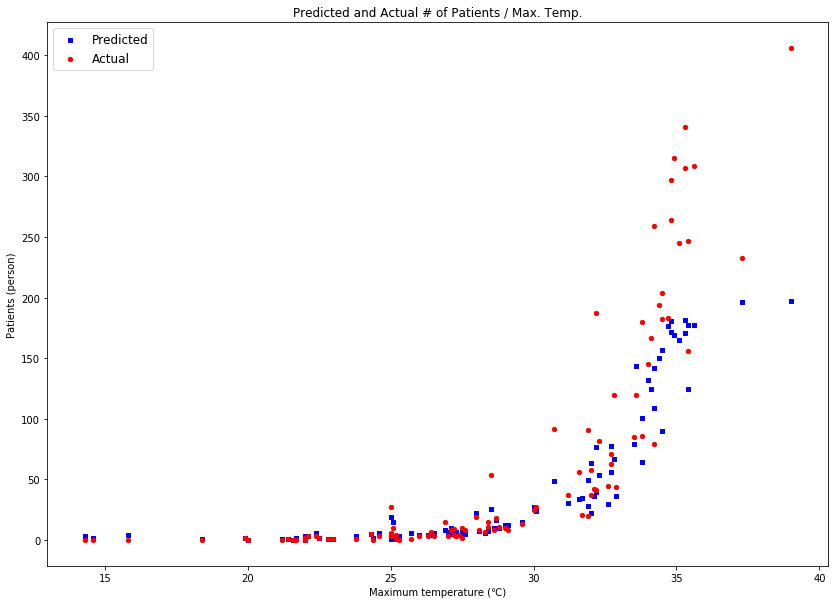

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "IPAexGothic"

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(111)

y_predict = model.predict(X_test) 

x_vals = X_test["最高気温(℃)"].values
y_actual = y_test

ax1.scatter(x_vals[:100], y_predict[:100], s=18, c='b', marker="s", label='Predicted')
ax1.scatter(x_vals[:100], y_actual[:100], s=18, c='r', marker="o", label='Actual')

ax1.set_xlabel('Maximum temperature (℃)')
ax1.set_title('Predicted and Actual # of Patients / Max. Temp.')
ax1.set_ylabel('Patients (person)')

plt.legend(loc='upper left', prop={'size': 12})
plt.rcParams.update({'font.size': 14})
plt.show()

### 上記のモデルの解釈の結果より2番目重要と判断されたパラメータの散布図

In [2]:
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(111)

# distance_vals = [x[4] for x in X_test.values]
x_vals = X_test["m前日の搬送人数"].values
y_actual = y_test

ax1.scatter(x_vals[:100], y_predict[:100], s=18, c='b', marker="s", label='Predicted')
ax1.scatter(x_vals[:100], y_actual[:100], s=18, c='r', marker="o", label='Actual')

ax1.set_xlabel('# of patients on the day before')
ax1.set_title('Predicted and Actual # of Patients on the Day / the Day Before')
ax1.set_ylabel('Patients (person)')

plt.legend(loc='upper left', prop={'size': 12})
plt.rcParams.update({'font.size': 14})
plt.show()

NameError: name 'plt' is not defined

結果：予測値の方が搬送人数を低く見積もっている傾向が見受けられる